In [1]:
# %%
from pathlib import Path

import torch
import numpy as np
import random
import pickle
from absl import logging
from absl.flags import FLAGS
from cellot import losses
from cellot.utils.loaders import load
from cellot.models.cellot import compute_loss_f, compute_loss_g, compute_w2_distance
from cellot.train.summary import Logger
from cellot.data.utils import cast_loader_to_iterator
from cellot.models.ae import compute_scgen_shift
from tqdm import trange

from cellot.models.ae import AutoEncoder

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
logger = logging.getLogger("data_logger")
logger.setLevel(logging.INFO)


In [2]:
DEBUG = True
TARGET = 'all' if not DEBUG else 'abexinostat'
LATENT_DIM = 50

from pathlib import Path
outdir_path = '/Mounts/rbg-storage1/users/johnyang/cellot/results/sciplex3/full_ae'
outdir = Path(outdir_path)

# %%
outdir.mkdir(exist_ok=True, parents=True)

cachedir = outdir / "cache"
cachedir.mkdir(exist_ok=True)

In [3]:

import torch
import GPUtil
import os

def get_free_gpu():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)
    # Set environment variables for which GPUs to use.
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    chosen_gpu = ''.join(
        [str(x) for x in GPUtil.getAvailable(order='memory')])
    os.environ["CUDA_VISIBLE_DEVICES"] = chosen_gpu
    print(f"Using GPUs: {chosen_gpu}")
    return chosen_gpu

status = cachedir / "status"
status.write_text("running")

device = f'cuda:{get_free_gpu()}'

cuda
Using GPUs: 5


In [4]:

# %%
import omegaconf

if DEBUG:
    n_iters = 250000
    batch_size = 256
else:
    n_iters = 250000
    batch_size = 256

yaml_str = f"""
model:
   name: scgen
   beta: 0.0
   dropout: 0.0
   hidden_units: [512, 512]
   latent_dim: 50

optim:
   lr: 0.001
   optimizer: Adam
   weight_decay: 1.0e-05

scheduler:
   gamma: 0.5
   step_size: 100000

training:
  cache_freq: 10000
  eval_freq: 2500
  logs_freq: 250
  n_iters: {n_iters}

data:
  type: cell
  source: control
  condition: drug
  path: /Mounts/rbg-storage1/users/johnyang/cellot/datasets/scrna-sciplex3/hvg.h5ad
  target: {TARGET}

datasplit:
    groupby: drug   
    name: train_test
    test_size: 0.2
    random_state: 0

dataloader:
    batch_size: {batch_size}
    shuffle: true
"""

config = omegaconf.OmegaConf.create(yaml_str)


In [5]:

# %% [markdown]
# ### Utils

# %%
def load_lr_scheduler(optim, config):
    if "scheduler" not in config:
        return None

    return torch.optim.lr_scheduler.StepLR(optim, **config.scheduler)

def check_loss(*args):
    for arg in args:
        if torch.isnan(arg):
            raise ValueError


def load_item_from_save(path, key, default):
    path = Path(path)
    if not path.exists():
        return default

    ckpt = torch.load(path)
    if key not in ckpt:
        logging.warn(f"'{key}' not found in ckpt: {str(path)}")
        return default

    return ckpt[key]

# %%
import cellot.models
from cellot.data.cell import load_cell_data


def load_data(config, **kwargs):
    data_type = config.get("data.type", "cell")
    if data_type in ["cell", "cell-merged", "tupro-cohort"]:
        loadfxn = load_cell_data

    elif data_type == "toy":
        loadfxn = load_toy_data

    else:
        raise ValueError

    return loadfxn(config, **kwargs)


def load_model(config, device, restore=None, **kwargs):
    # def load_autoencoder_model(config, restore=None, **kwargs):
    
    def load_optimizer(config, params):
        kwargs = dict(config.get("optim", {}))
        assert kwargs.pop("optimizer", "Adam") == "Adam"
        optim = torch.optim.Adam(params, **kwargs)
        return optim


    def load_networks(config, **kwargs):
        kwargs = kwargs.copy()
        kwargs.update(dict(config.get("model", {})))
        name = kwargs.pop("name")

        if name == "scgen":
            model = AutoEncoder

        # elif name == "cae":
        #     model = ConditionalAutoEncoder
        else:
            raise ValueError

        return model(**kwargs)
    
    model = load_networks(config, **kwargs)
    optim = load_optimizer(config, model.parameters())

    if restore is not None and Path(restore).exists():
        print('Loading model from checkpoint')
        ckpt = torch.load(restore, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optim.load_state_dict(ckpt["optim_state"])
        if config.model.name == "scgen" and "code_means" in ckpt:
            model.code_means = ckpt["code_means"]
            
    # logger.info(f'Model on device {next(model.parameters()).device}')

    return model, optim

def load(config, device, restore=None, include_model_kwargs=False, **kwargs):

    loader, model_kwargs = load_data(config, include_model_kwargs=True, **kwargs)

    model, opt = load_model(config, device, restore=restore, **model_kwargs)

    # if include_model_kwargs:
    #     return model, opt, loader, model_kwargs

    return model, opt, loader

# %% [markdown]
# ### Training


In [6]:
def state_dict(model, optim, **kwargs):
    state = {
        "model_state": model.state_dict(),
        "optim_state": optim.state_dict(),
    }

    if hasattr(model, "code_means"):
        state["code_means"] = model.code_means

    state.update(kwargs)

    return state

def evaluate(vinputs):
    with torch.no_grad():
        loss, comps, _ = model(vinputs)
        loss = loss.mean()
        comps = {k: v.mean().item() for k, v in comps._asdict().items()}
        check_loss(loss)
        logger.log("eval", loss=loss.item(), step=step, **comps)
    return loss

In [7]:
# _, _, loader = load(config, 'cuda', restore=cachedir / "last.pt")

In [8]:
"""R^3 diffusion methods."""
import numpy as np
from scipy.special import gamma
import torch


class R3Diffuser:
    """VP-SDE diffuser class for translations."""

    def __init__(self, r3_conf):
        """
        Args:
            min_b: starting value in variance schedule.
            max_b: ending value in variance schedule.
        """
        self._r3_conf = r3_conf
        self.min_b = r3_conf.min_b
        self.max_b = r3_conf.max_b
        self.schedule = r3_conf.schedule
        self._score_scaling = r3_conf.score_scaling
        self.latent_dim = r3_conf.latent_dim

    def _scale(self, x):
        return x * self._r3_conf.coordinate_scaling

    def _unscale(self, x):
        return x / self._r3_conf.coordinate_scaling

    def b_t(self, t):
        if np.any(t < 0) or np.any(t > 1):
            raise ValueError(f'Invalid t={t}')
        if self.schedule == 'linear': 
            return self.min_b + t*(self.max_b - self.min_b)
        elif self.schedule == 'cosine':
            return self.max_b + 0.5*(self.min_b - self.max_b)*(1 + np.cos(t*np.pi))
        elif self.schedule == 'exponential':
            sigma = t * np.log10(self.max_b) + (1 - t) * np.log10(self.min_b)
            return 10 ** sigma
        else:
            raise ValueError(f'Unknown schedule {self.schedule}')
    
    def diffusion_coef(self, t):
        """Time-dependent diffusion coefficient."""
        return np.sqrt(self.b_t(t))

    def drift_coef(self, x, t):
        """Time-dependent drift coefficient."""
        return -1/2 * self.b_t(t) * x

    def sample_ref(self, n_samples: float=1):
        return np.random.normal(size=(n_samples, self.latent_dim))

    def marginal_b_t(self, t):
        if self.schedule == 'linear':
            return t*self.min_b + (1/2)*(t**2)*(self.max_b-self.min_b)
        elif self.schedule == 'exponential': 
            return (self.max_b**t * self.min_b**(1-t) - self.min_b) / (
                np.log(self.max_b) - np.log(self.min_b))
        else:
            raise ValueError(f'Unknown schedule {self.schedule}')

    def calc_trans_0(self, score_t, x_t, t, use_torch=True):
        beta_t = self.marginal_b_t(t)
        beta_t = beta_t[..., None, None]
        exp_fn = torch.exp if use_torch else np.exp
        cond_var = 1 - exp_fn(-beta_t)
        return (score_t * cond_var + x_t) / exp_fn(-1/2*beta_t)

    def forward(self, x_t_1: np.ndarray, t: float, num_t: int):
        """Samples marginal p(x(t) | x(t-1)).

        Args:
            x_0: [..., n, 3] initial positions in Angstroms.
            t: continuous time in [0, 1]. 

        Returns:
            x_t: [..., n, 3] positions at time t in Angstroms.
            score_t: [..., n, 3] score at time t in scaled Angstroms.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t_1 = self._scale(x_t_1)
        b_t = torch.tensor(self.marginal_b_t(t) / num_t).to(x_t_1.device)
        z_t_1 = torch.tensor(np.random.normal(size=x_t_1.shape)).to(x_t_1.device)
        x_t = torch.sqrt(1 - b_t) * x_t_1 + torch.sqrt(b_t) * z_t_1
        return x_t
    
    def distribution(self, x_t, score_t, t, mask, dt):
        x_t = self._scale(x_t)
        g_t = self.diffusion_coef(t)
        f_t = self.drift_coef(x_t, t)
        std = g_t * np.sqrt(dt)
        mu = x_t - (f_t - g_t**2 * score_t) * dt
        if mask is not None:
            mu *= mask[..., None]
        return mu, std

    def forward_marginal(self, x_0: np.ndarray, t: float):
        """Samples marginal p(x(t) | x(0)).

        Args:
            x_0: [..., n, 3] initial positions in Angstroms.
            t: continuous time in [0, 1]. 

        Returns:
            x_t: [..., n, 3] positions at time t in Angstroms.
            score_t: [..., n, 3] score at time t in scaled Angstroms.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_0 = self._scale(x_0)
        x_t = np.random.normal(
            loc=np.exp(-1/2*self.marginal_b_t(t)) * x_0,
            scale=np.sqrt(1 - np.exp(-self.marginal_b_t(t)))
        )
        score_t = self.score(x_t, x_0, t)
        x_t = self._unscale(x_t)
        return x_t, score_t

    def score_scaling(self, t: float):
        if self._score_scaling == 'var':
            return 1 / self.conditional_var(t)
        elif self._score_scaling == 'std':
            return 1 / np.sqrt(self.conditional_var(t))
        elif self._score_scaling == 'expected_norm':
            return np.sqrt(2) / (gamma(1.5) * np.sqrt(self.conditional_var(t)))
        else:
            raise ValueError(f'Unrecognized scaling {self._score_scaling}')

    def reverse(
            self,
            *,
            x_t: np.ndarray,
            score_t: np.ndarray,
            t: float,
            dt: float,
            mask: np.ndarray=None,
            center: bool=True,
            ode: bool=False,
            noise_scale: float=1.0,
        ):
        """Simulates the reverse SDE for 1 step

        Args:
            x_t: [..., 3] current positions at time t in angstroms.
            score_t: [..., 3] rotation score at time t.
            t: continuous time in [0, 1].
            dt: continuous step size in [0, 1].
            mask: True indicates which residues to diffuse.

        Returns:
            [..., 3] positions at next step t-1.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t = self._scale(x_t)
        g_t = self.diffusion_coef(t)
        f_t = self.drift_coef(x_t, t)
        if ode:
            # Probability flow ODE
            perturb = (f_t - (1/2)*(g_t**2) * score_t) * dt
        else:
            # Usual stochastic dynamics
            z = noise_scale * np.random.normal(size=score_t.shape)
            perturb = (f_t - g_t**2 * score_t) * dt + g_t * np.sqrt(dt) * z

        if mask is not None:
            perturb *= mask[..., None]
        else:
            mask = np.ones(x_t.shape[:-1])
        x_t_1 = x_t - perturb
        if center:
            com = np.sum(x_t_1, axis=-2) / np.sum(mask, axis=-1)[..., None]
            x_t_1 -= com[..., None, :]
        x_t_1 = self._unscale(x_t_1)
        return x_t_1

    def conditional_var(self, t, use_torch=False):
        """Conditional variance of p(xt|x0).

        Var[x_t|x_0] = conditional_var(t)*I

        """
        if use_torch:
            return 1 - torch.exp(-self.marginal_b_t(t))
        return 1 - np.exp(-self.marginal_b_t(t))

    def score(self, x_t, x_0, t, use_torch=False, scale=False):
        if use_torch:
            exp_fn = torch.exp
        else:
            exp_fn = np.exp
        if scale:
            x_t = self._scale(x_t)
            x_0 = self._scale(x_0)
        return -(x_t - exp_fn(-1/2*self.marginal_b_t(t)) * x_0) / self.conditional_var(t, use_torch=use_torch)

In [9]:
from omegaconf import OmegaConf

r3_conf = OmegaConf.create({
    'min_b': 0.01,
    'max_b': 1.0,
    'schedule': 'linear',
    'score_scaling': 'var',
    'coordinate_scaling': 1.0,
    'latent_dim': LATENT_DIM,
})

In [10]:
diffuser = R3Diffuser(r3_conf)

In [11]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer, Linear
import torch.nn as nn

In [12]:
model_dim = 64
num_layers = 2
nhead = 1
dim_feedforward = 128
dropout = 0.1 if not DEBUG else 0.0

import torch.nn as nn
import torch.nn.functional as F
import math
import functools as fn

class FeedForward(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=64, output_dim=50):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def get_timestep_embedding(timesteps, embedding_dim, max_positions=10000):
    # Code from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py
    assert len(timesteps.shape) == 1
    timesteps = timesteps * max_positions
    half_dim = embedding_dim // 2
    emb = math.log(max_positions) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, (0, 1), mode='constant')
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb

class ScoreNetwork(nn.Module):
    def __init__(self):
        super(ScoreNetwork, self).__init__()
        
        self.latent_dim = LATENT_DIM
        self.model_dim = model_dim
        self.dropout = dropout
        print(f'Dropout is {self.dropout}')
        self.embed_code_and_t = nn.Linear(LATENT_DIM + model_dim, model_dim)
        # self.trmr_layer = TransformerEncoderLayer(d_model=model_dim, nhead=8, dim_feedforward=2048, dropout=dropout)
        self.pred_score = FeedForward(input_dim=model_dim, hidden_dim=64, output_dim=LATENT_DIM)
        self.model = nn.ModuleList([self.embed_code_and_t, self.pred_score]) #*[self.trmr_layer for _ in range(num_layers)], self.pred_score])
        
        self.timestep_embedder = fn.partial(
            get_timestep_embedding,
            embedding_dim=self.model_dim,
            # max_positions=100
        )

    def forward(self, x, t):
        device = x.device
        B, C = x.shape
        t_embed = torch.tile(self.timestep_embedder(torch.tensor([t]).to(device)), dims=[B, 1])
        
        x = torch.cat([x, t_embed], dim=-1).to(device)
        
        for module in self.model[:-1]:  # iterate over all modules except the last one
            x = module(x)
        x = self.model[-1](x.squeeze(0))  # pass through the last module (FeedForward)
        return x

In [13]:
score_network = ScoreNetwork().to(device)

Dropout is 0.0


In [14]:
sum(p.numel() for p in score_network.parameters())

14770

In [15]:
optimizer = torch.optim.Adam(score_network.parameters(), lr=1e-4)

In [16]:
STEP = 0
ticker = trange(STEP, n_iters, initial=STEP, total=n_iters)

  0%|                                                                                                                                                                         | 0/250000 [00:00<?, ?it/s]

In [17]:
# iterator = cast_loader_to_iterator(loader, cycle_all=True)

In [18]:
# inputs = next(iterator.train).to(device)
# inputs.shape

In [19]:
# ae.to(device)

In [20]:
# with torch.no_grad():
#     ex_code = ae.encode(ex_batch).to(device)[None, 0, :1]

In [21]:
# ex_code

In [22]:
# Create a tensor of values from 0 to 255
values = torch.arange(256).float().to(device)

# Add an extra dimension to this tensor and replicate it along the new dimension
ex_code = values.unsqueeze(1).expand(-1, 50)

print(ex_code.shape)  # Outputs: torch.Size([256, 50])
print(ex_code)  # Outputs a 256x50 tensor where each row i contains the value i

torch.Size([256, 50])
tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  1.,   1.,   1.,  ...,   1.,   1.,   1.],
        [  2.,   2.,   2.,  ...,   2.,   2.,   2.],
        ...,
        [253., 253., 253.,  ..., 253., 253., 253.],
        [254., 254., 254.,  ..., 254., 254., 254.],
        [255., 255., 255.,  ..., 255., 255., 255.]], device='cuda:5')


In [23]:
ex_code.shape

torch.Size([256, 50])

In [24]:
min_t = 0.0
rng = np.random.default_rng(42)

In [29]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/6.29.23_just_mlp_KD_batching')


In [30]:
import torch
torch.__version__

'2.0.1'

In [31]:
def eval(dt=0.001):
    score_network.eval()
    # log_freq = (1 / dt) / 100
    ex_code_np = ex_code.detach().cpu().numpy()
    with torch.no_grad():
        x_t, _ = diffuser.forward_marginal(ex_code_np, t=1.0)
        
        for i, t in enumerate(np.arange(1.0, 0, -dt)):
            # if i % log_freq == 0:
                # print(x_t)
            x_t = torch.tensor(x_t).float().to(device)
            pred_score = score_network(x_t, t)
            
            # pred_scores.append(pred_score)
            # gt_scores.append(gt_score)
            
            # _, gt_score = diffuser.forward_marginal(ex_code_np.detach().cpu().numpy(), t=t)

            # print(pred_score, gt_score)
            
            x_t = diffuser.reverse(x_t=x_t.detach().cpu().numpy(), score_t=pred_score.detach().cpu().numpy(), t=t, dt=dt, center=False)
        
        x_0 = x_t
        writer.add_embedding(x_0, global_step=step, tag='reverse_sampled_x_0')
        writer.add_embedding(ex_code_np, global_step=step, tag='gt_x_0')
        euclidean_distance = np.linalg.norm(x_0 - ex_code_np)
        writer.add_scalar('sampled_gt_dist', euclidean_distance, global_step=step)
        
        return x_0

In [32]:
eval_freq=1000
for step in ticker:

    score_network.train()
    
    # if DEBUG:
    #     inputs = ex_batch
    # else:
    #     raise NotImplementedError
    #     inputs = next(iterator.train)
    #     # inputs = inputs.to(device)
        
        
    optimizer.zero_grad()
    # '''
    # Get encoded representation
    # '''
    
    # code = ae.encode(inputs)
    
    t = rng.uniform(min_t, 1.0)
    x_t, gt_score_t = diffuser.forward_marginal(ex_code.detach().cpu().numpy(), t=t)
    
    score_scaling = torch.tensor(diffuser.score_scaling(t)).to(device)
    gt_score_t = torch.tensor(gt_score_t).to(device)
    
    pred_score_t = score_network(torch.tensor(x_t).float().to(device), t)

    score_mse = (gt_score_t - pred_score_t)**2
    score_loss = torch.sum(
        score_mse / score_scaling[None, None]**2,
        dim=(-1, -2)
    ) #/ (loss_mask.sum(dim=-1) + 1e-10)    
    
    # comps = {k: v.mean().item() for k, v in comps._asdict().items()}
    score_loss.backward()
    optimizer.step()
    # check_loss(score_)

    if step % config.training.logs_freq == 0:
        # log to logger object
        # logger.log("train", loss=loss.item(), step=step, **comps)
        writer.add_scalar('Training loss', score_loss.item(), global_step=step)
        print(f'At step {step}, TRAINING loss is {score_loss.item()}')
        
    if step % eval_freq == 0:
        sampled_x_0 = eval(dt=0.01)
        print(f'At step {step}, sampled x_0 is {sampled_x_0[:2, :2]}')


At step 0, TRAINING loss is 872.6554551147299
At step 0, sampled x_0 is [[ 1.02796395  0.51237074]
 [-0.13835956  2.03075597]]
At step 250, TRAINING loss is 99.81891947133073
At step 500, TRAINING loss is 4869.650151452273
At step 750, TRAINING loss is 3407.3039797228657
At step 1000, TRAINING loss is 2255.2377913351957
At step 1000, sampled x_0 is [[-0.29557414 -0.60666118]
 [-0.29559674  2.84456002]]
At step 1250, TRAINING loss is 2271.250339482431
At step 1500, TRAINING loss is 3342.055818482766
At step 1750, TRAINING loss is 4975.948728008503
At step 2000, TRAINING loss is 221.68205110310987
At step 2000, sampled x_0 is [[0.22096445 0.67141534]
 [1.19126193 0.75107358]]
At step 2250, TRAINING loss is 1431.894845561876
At step 2500, TRAINING loss is 1488.664210488067
At step 2750, TRAINING loss is 652.5694562655735
At step 3000, TRAINING loss is 2884.551349078899
At step 3000, sampled x_0 is [[ 0.1554642  -1.03517112]
 [ 0.29189294  0.04878044]]
At step 3250, TRAINING loss is 2124.1

In [ ]:
torch.save(score_network, '6.29.23.1D_mlp_score_network.pt')

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

/data/rsg/chemistry/johnyang/miniconda3/envs/cellot/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Sampling x_t from learned reverse process, gt x_0 = 1.0, random init')

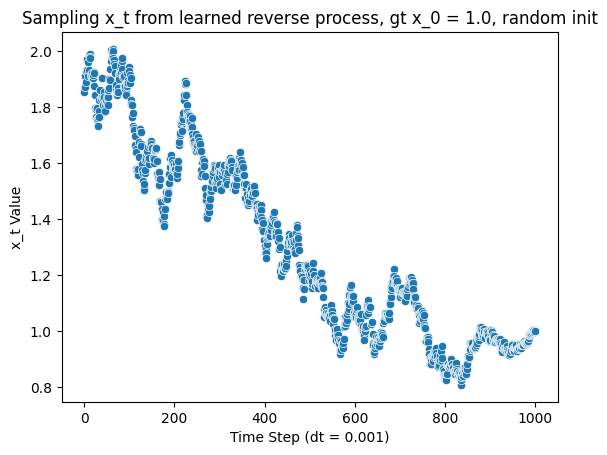

In [49]:
sns.scatterplot([x for x in range(len(x_t_list))], x_t_list)
plt.xlabel('Time Step (dt = 0.001)')
plt.ylabel('x_t Value')
plt.title('Sampling x_t from learned reverse process, gt x_0 = 1.0, random init')